<a href="https://colab.research.google.com/github/singhvikasguru/BT/blob/master/fine_tune_FChq_nchq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==1.12.0
import tensorflow as tf
print(tf.__version__)

In [1]:
!pip install q keras==2.2.2 

In [0]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir gdrive
!google-drive-ocamlfuse gdrive
!ls gdrive
!cd gdrive

In [4]:
!ls gdrive
!cd gdrive
!ls gdrive

10April19.zip	   dummy225.h5	    new_model2.h5     non-cheque.zip
9April19.zip	   dummy25.h5	    new_model3.h5     non_chq_f.zip
AI_0_9_Images.zip  dummy.h5	    new_model.h5
cheque.zip	   fine_model_2.h5  new_non_chq2.zip
Data		   fine_model.h5    new_non_chq.zip
10April19.zip	   dummy225.h5	    new_model2.h5     non-cheque.zip
9April19.zip	   dummy25.h5	    new_model3.h5     non_chq_f.zip
AI_0_9_Images.zip  dummy.h5	    new_model.h5
cheque.zip	   fine_model_2.h5  new_non_chq2.zip
Data		   fine_model.h5    new_non_chq.zip


In [0]:
import zipfile
a=!unzip gdrive/cheque.zip
a2=!unzip gdrive/non-cheque.zip

In [0]:
#a2=!unzip gdrive/non_chq_f.zip

In [0]:
a

In [6]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import gc
import glob
import matplotlib.image as mping
import seaborn as sns
from sklearn.model_selection import train_test_split

#model import
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [0]:

chq_images=[]
for x in a[2:602]:
  sp=x.split(':')
  sp2=sp[1]
  sp2=sp2.strip()
  chq_images.append(cv2.imread(sp2))

In [0]:
nchq_images=[]
for x in a2[2:1800]:
  sp=x.split(':')
  sp2=sp[1]
  sp2=sp2.strip()
  nchq_images.append(cv2.imread(sp2))

In [0]:

fchq_images=chq_images[0:602]
#del chq_images
#gc.collect()

In [20]:
print(len(fchq_images))
print(len(nchq_images))

600
1798


In [21]:
n=500
train_images=nchq_images[:(3*n)]+fchq_images[:int(n)]
train_labels=[0 for x in range(0, 3*n)]
for i in range(0, int(n)):
    train_labels.append(1)
zip_train=list(zip(train_images, train_labels))
random.shuffle(zip_train)
train_images, train_labels=zip(*zip_train)

test_images=fchq_images[n:(n+100)]+nchq_images[n:(n+100)]

del fchq_images
del nchq_images
gc.collect()

77

In [22]:
len(train_images)

2000

In [0]:
nrows=150
ncols=150
channels=1 # 3 if colour image is needed
X=[]
X_test=[]
for img in train_images:
    X.append(cv2.resize(img, (nrows, ncols), interpolation=cv2.INTER_CUBIC))
for img in test_images:
    X_test.append(cv2.resize(img, (nrows, ncols), interpolation=cv2.INTER_CUBIC))
Y=train_labels
Y=np.asarray(Y)
X=np.asarray(X)
X_test=np.asarray(X_test)

#del train_images
#gc.collect()

In [12]:
del test_images
gc.collect()

0

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Labels')

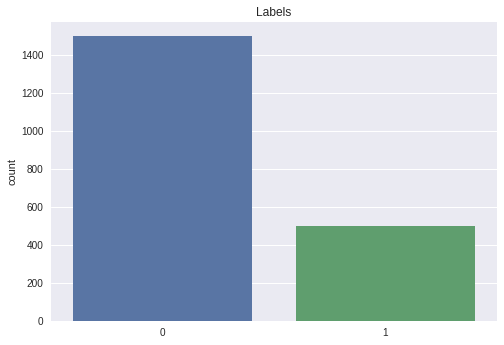

In [24]:
sns.countplot(Y)
plt.title("Labels")    

In [25]:
X_train, X_val, y_train, y_val=train_test_split(X, Y, test_size=0.2, random_state=2)

del X
del Y
gc.collect()

0

In [26]:
from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

Instructions for updating:
Colocations handled automatically by placer.
219062272/219055592 [==============================] - 17s 0us/step


In [0]:
conv_base.summary()

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

In [0]:
model.summary()

In [28]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

NameError: ignored

In [0]:
#We'll use the RMSprop optimizer with a learning rate of 0.0001
#We'll use binary_crossentropy loss because its a binary classification
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [0]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [0]:
train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [0]:
#The training part
#We train for 64 epochs with about 100 steps per epoch
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)


In [0]:
model=models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])


In [0]:
train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen=ImageDataGenerator(rescale=1./255)

batch_size=32
train_genrator=train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_genrator=val_datagen.flow(X_val, y_val, batch_size=batch_size)
history=model.fit_generator(train_genrator, steps_per_epoch=X_train.shape[0]//batch_size, epochs=40 , validation_data=val_genrator, validation_steps=X_val.shape[0]//batch_size)


In [0]:
history=model.fit_generator(train_genrator, steps_per_epoch=X_train.shape[0]//batch_size, epochs=40 , validation_data=val_genrator, validation_steps=X_val.shape[0]//batch_size)


In [0]:
#model.save_weights('gdrive/dummy2.h5')
model.save('gdrive/fine_model_2.h5')

In [0]:
acc=history.history['acc']
val_acc=history.history['val_acc'] 
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [0]:
X_test.shape

(200, 150, 150, 3)

In [0]:
y_pred=model.predict(X_test)
label_pred=[]
for x in y_pred:
    if x>0.01:
        label_pred.append('Cheque')
    else:
        label_pred.append('Not-Cheque')

In [0]:
X_test2=X_test/255
y_pred2=model.predict(X_test2)
label_pred2=[]
for x in y_pred2:
    if x>0.05:
        label_pred2.append('Cheque')
    else:
        label_pred2.append('Not-Cheque')

In [0]:
label_pred2

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
x=X_test
columns=2*100 
i = 0
text_labels = []
predl=[]
#plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    predl.append(pred)
    if pred > 0.01:
        text_labels.append('Cheque')
    else:
        text_labels.append('Non-Cheque')
    #plt.subplot(2*100 / columns + 1, columns, i + 1)
    #plt.title('This is a ' + text_labels[i])
    #imgplot = plt.imshow(batch[0])
    i+=1
    if i%200==0:
        break;

#plt.show()

In [0]:
ind=[x for x in range(0, 200)]
aa=list(zip(ind, label_pred, text_labels))
aa2=list(zip(ind, label_pred))
aa3=list(zip(ind, text_labels))
aa4=list(zip(ind, label_pred2))

In [0]:
print(aa)
print(aa2)
print(aa3)
print(aa4)

[(0, 'Not-Cheque', 'Cheque'), (1, 'Not-Cheque', 'Cheque'), (2, 'Not-Cheque', 'Cheque'), (3, 'Not-Cheque', 'Cheque'), (4, 'Not-Cheque', 'Cheque'), (5, 'Not-Cheque', 'Cheque'), (6, 'Not-Cheque', 'Cheque'), (7, 'Not-Cheque', 'Non-Cheque'), (8, 'Not-Cheque', 'Cheque'), (9, 'Not-Cheque', 'Cheque'), (10, 'Not-Cheque', 'Cheque'), (11, 'Not-Cheque', 'Cheque'), (12, 'Not-Cheque', 'Non-Cheque'), (13, 'Not-Cheque', 'Cheque'), (14, 'Not-Cheque', 'Non-Cheque'), (15, 'Not-Cheque', 'Cheque'), (16, 'Not-Cheque', 'Cheque'), (17, 'Not-Cheque', 'Non-Cheque'), (18, 'Not-Cheque', 'Non-Cheque'), (19, 'Not-Cheque', 'Cheque'), (20, 'Not-Cheque', 'Cheque'), (21, 'Not-Cheque', 'Cheque'), (22, 'Not-Cheque', 'Non-Cheque'), (23, 'Not-Cheque', 'Cheque'), (24, 'Not-Cheque', 'Cheque'), (25, 'Not-Cheque', 'Non-Cheque'), (26, 'Not-Cheque', 'Non-Cheque'), (27, 'Not-Cheque', 'Cheque'), (28, 'Not-Cheque', 'Cheque'), (29, 'Not-Cheque', 'Cheque'), (30, 'Not-Cheque', 'Cheque'), (31, 'Not-Cheque', 'Cheque'), (32, 'Not-Cheque'

In [0]:
print(np.asarray(text_labels))

In [0]:
test_labels=[1 for x in range(0,100)]
for x in range(0, 100):
  test_labels.append(0)
loss,acc = model.evaluate(X_test, test_labels)
print(loss, acc)

200/200 [==============================] - 0s 933us/step
8.059047734974616 0.5


In [0]:
del X_train
del X_val
del y_train
del y_val
gc.collect()

5366

In [0]:
gc.collect()

0

In [0]:
from keras.models import load_model
model=load_model('gdrive/new_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
import zipfile
!ls gdrive
at=!unzip gdrive/AI_0_9_Images.zip

In [0]:
len(at)

In [0]:
images=[]
for x in at[2:174]:
  sp=x.split(':')
  sp2=sp[1]
  sp2=sp2.strip()
  images.append(cv2.imread(sp2))

In [0]:
nrows=150
ncols=150

In [0]:
X_test=[]
for img in images:
    X_test.append(cv2.resize(img, (nrows, ncols), interpolation=cv2.INTER_CUBIC))

In [0]:
len(X_test)
X_test=np.asarray(X_test)


In [0]:
X_test=X_test/255

In [0]:
X_test

In [0]:
model.predict(X_test)

In [0]:
a[2:174]

In [0]:
import keras; print(keras.__version__)

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
x=X_test
columns=2*100 
i = 0
text_labels = []
predl=[]
#plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    predl.append(pred)
    if pred > 0.9:
        text_labels.append('Cheque')
    else:
        text_labels.append('Non-Cheque')
    #plt.subplot(2*100 / columns + 1, columns, i + 1)
    #plt.title('This is a ' + text_labels[i])
    #imgplot = plt.imshow(batch[0])
    i+=1
    if i%172==0:
        break;

In [0]:
text_labels